In [93]:
import pandas as pd
import numpy as np
import os
import json
import glob
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm


In [2]:
with open('../parameters.json') as json_data:
    params = json.load(json_data)

DATA_DIR = params['DIRECTORIES']['DATA_DIR']
TMP_DIR = params['DIRECTORIES']['TMP_DIR']
PRICE_FILE = params['FILES']['PRICE_FILE']
STATION_FILE = params['FILES']['STATION_FILE']
SERVICE_FILE = params['FILES']['SERVICE_FILE']
GAS_DB = os.path.join(DATA_DIR, params['DATABASES']['GAS_DB'])

In [4]:
dfall = pd.read_pickle(os.path.join(DATA_DIR,PRICE_FILE))
dfservices = pd.read_pickle(os.path.join(DATA_DIR,SERVICE_FILE))
dfstations = pd.read_pickle(os.path.join(DATA_DIR,STATION_FILE))

In [8]:
dfall['date_releve'] = pd.to_datetime(dfall.date_releve)

### Calcul de l'indice de prix hebdomadaire

In [14]:
moyenne_hebdo_df = (dfall
 .dropna(subset=['date_releve'])
 .groupby(['libelle_carburant', pd.Grouper(key='date_releve', freq='1W-MON')])
 .agg({'prix': np.mean})
 .reset_index()
)

In [26]:
model_df = (dfall
 .dropna(subset=['date_releve'])
 .groupby(['id_station', 'code_postal', 'type_station', 'libelle_carburant',
           pd.Grouper(key='date_releve', freq='1W-MON')])
 .agg({'prix': np.mean})
 .reset_index()
 .merge(moyenne_hebdo_df, how='inner', on=['libelle_carburant', 'date_releve'],
          suffixes=('', '_moyen'))
 .assign(indice = lambda _df: _df['prix'] / _df['prix_moyen'])
)

### Construction du vecteur de services

In [37]:
vectorize = CountVectorizer(tokenizer=lambda x: x.split(','), lowercase=False)

In [42]:
matrice_services_df = pd.SparseDataFrame(vectorize.fit_transform(dfservices.services.fillna('Rien')),
                   dfservices.id_station,
                   vectorize.get_feature_names(),
                   default_fill_value=0
                  ).reset_index()

In [128]:
model_services_df = model_df.merge(matrice_services_df, how='inner', on=['id_station'])
model_services_df['Rural'] = np.where(model_services_df.type_station == 'R', 1, 0)

In [133]:
liste_variables = list(set(matrice_services_df.columns)-{'id_station'} | {'Rural'})

### Modélisation (régression linéaire)

In [135]:
lr = LinearRegression(fit_intercept=True)

In [136]:
lr.fit(X=model_services_df[liste_variables],
       y=model_services_df.indice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [137]:
resultats = pd.DataFrame(
    [(f, c) for f, c in zip(liste_variables, lr.coef_)],
    columns=['Service', 'Coefficient']).sort_values('Coefficient', ascending=False)

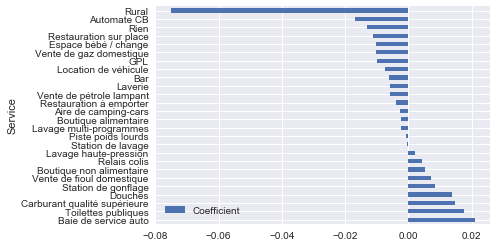

In [138]:
resultats.set_index('Service').plot(kind='barh')

In [139]:
X2 = sm.add_constant(model_services_df[liste_variables])
est = sm.OLS(model_services_df.indice, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 indice   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                 8.269e+04
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        16:48:53   Log-Likelihood:             6.0605e+06
No. Observations:             3220964   AIC:                        -1.212e+07
Df Residuals:                 3220937   BIC:                        -1.212e+07
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Modélisation (*Random Regressor*)

In [94]:
rf = RandomForestRegressor()

In [140]:
rf.fit(X=model_services_df[liste_variables],
       y=model_services_df.indice)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [141]:
resultats_rf = pd.DataFrame(
    [(f, c) for f, c in zip(liste_variables,
                            rf.feature_importances_)],
    columns=['Service', 'Coefficient']).sort_values('Coefficient', ascending=False)

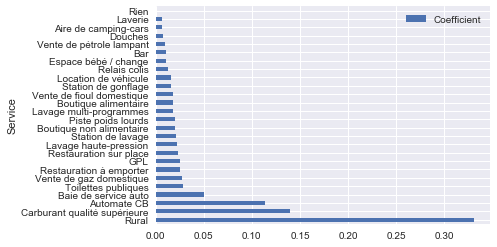

In [142]:
resultats_rf.set_index('Service').plot(kind='barh')

In [143]:
model_services_df.groupby('Rural')['indice'].mean()

Rural
0    1.093417
1    0.998797
Name: indice, dtype: float64